In [301]:
# import preprocessing from sklearn
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import  preprocessing, metrics,  cross_validation
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# load dataset
pathDataset = "../Dataset/results.xlsx"
original_dataset  = pd.read_excel(pathDataset)

#Format date column to date time
#dataset['date'] = pd.to_datetime(X.date)
original_dataset['date'] =  pd.to_datetime(original_dataset['date'], format='%Y/%m/%d')
original_dataset['date'] =  pd.to_datetime(original_dataset['date'], format='%Y%-m-%d')
#original_dataset.dtypes
#original_dataset.describe()

#Add target column to our dataset 
#Create a new function:
def add_target(home, away):
    data = "equal"
    if home > away : 
        data = "Home winner"
    elif away > home : 
        data = "away winner"
    return data
original_dataset['target'] = original_dataset.apply(lambda x: add_target(x['home_score'], x['away_score']), axis=1)


# Split new dataset in Train and Test sub-sets
tarining_dataset = original_dataset[0:20948]
test_dataset = original_dataset[20949:38685]


# Training sub-dataset
X_train = tarining_dataset.iloc[:, 0:9]
Y_train = tarining_dataset.iloc[:, 8]

# Test sub-dataset
X_test = test_dataset.iloc[:, 0:9]
Y_test = test_dataset.iloc[:, 8]

#Display 3 first rows
original_dataset.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,target
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,equal
1,1872-11-30,England,Scotland,4,2,Friendly,London,England,Home winner
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Home winner
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,equal
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Home winner


In [283]:
# limit to categorical data using df.select_dtypes()
#columns_categorical_subset = original_dataset.select_dtypes(include=[object])
#columns_categorical_subset.head(3)

In [284]:
# check original shape
#columns_categorical_subset.shape
# Y_test3 = to_categorical(y_test3, num_classes)

In [285]:
# view columns using df.columns
#columns_categorical_subset

In [286]:
# TODO: create a LabelEncoder object and fit it to each feature in X
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
final_dataset = original_dataset.apply(le.fit_transform)
final_dataset['target'] = original_dataset['target']
final_dataset.head(3)


,date,home_team,away_team,home_score,away_score,tournament,city,country,target
0,0,184,64,0,0,47,559,201,equal
1,0,65,180,4,2,47,890,68,Home winner
2,1,184,64,2,1,47,559,201,Home winner


In [287]:
# TODO: create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
#enc = preprocessing.OneHotEncoder()

# 2. FIT
#enc.fit(final_dataset)

# 3. Transform
#onehotlabels = enc.transform(final_dataset).toarray()
#onehotlabels
# Explication: 
# as you can see, you've the same number of rows 891
# but now you've so many more columns due to how we changed all the categorical data into numerical data

def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

fd_encoded, targets = encode_target(final_dataset, "target")
print("* df2.head()", fd_encoded[["Target", "target"]].head(),
      sep="\n", end="\n\n")
print("* df2.tail()", fd_encoded[["Target", "target"]].tail(),
      sep="\n", end="\n\n")
print("* targets", targets, sep="\n", end="\n\n")

* df2.head()
   Target       target
0       0        equal
1       1  Home winner
2       1  Home winner
3       0        equal
4       1  Home winner

* df2.tail()
       Target       target
38680       1  Home winner
38681       0        equal
38682       0        equal
38683       1  Home winner
38684       1  Home winner

* targets
['equal' 'Home winner' 'away winner']



In [288]:
features = list(final_dataset.columns[:8])
print("* features:", features, sep="\n")


* features:
['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country']


In [289]:
# Split new dataset in Train and Test sub-sets
tarining_dataset = fd_encoded[0:20948]
test_dataset = fd_encoded[20949:38685]

# Training sub-dataset
X_train = tarining_dataset[features]
Y_train = tarining_dataset["Target"]
print("###################################")

# Test sub-dataset
X_test = test_dataset[features]
Y_test = test_dataset["Target"]



###################################


#Decision Tree: 

In [290]:
#Instanciate the model classifier
print("Instanciate the model classifier with CART algorithm .....")
model_dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)

print("Train .....")
model_dt.fit(X_train, Y_train)



Instanciate the model classifier with CART algorithm .....
Train .....


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [299]:
#Performance: Method 2 to predict, confusion matrix and showing accuracy
def measure_performance(X,y,dt_model, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=dt_model.predict(X)   
    if show_accuracy:
        print ("############################################################")
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("############################################################")
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("############################################################")
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_test,Y_test,model_dt, show_classification_report=True, show_confusion_matrix=True)

############################################################
Accuracy:1.000 

############################################################
Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4257
          1       1.00      1.00      1.00      8473
          2       1.00      1.00      1.00      5006

avg / total       1.00      1.00      1.00     17736
 

############################################################
Confusion matrix
[[4256    1    0]
 [   0 8473    0]
 [   0    0 5006]] 



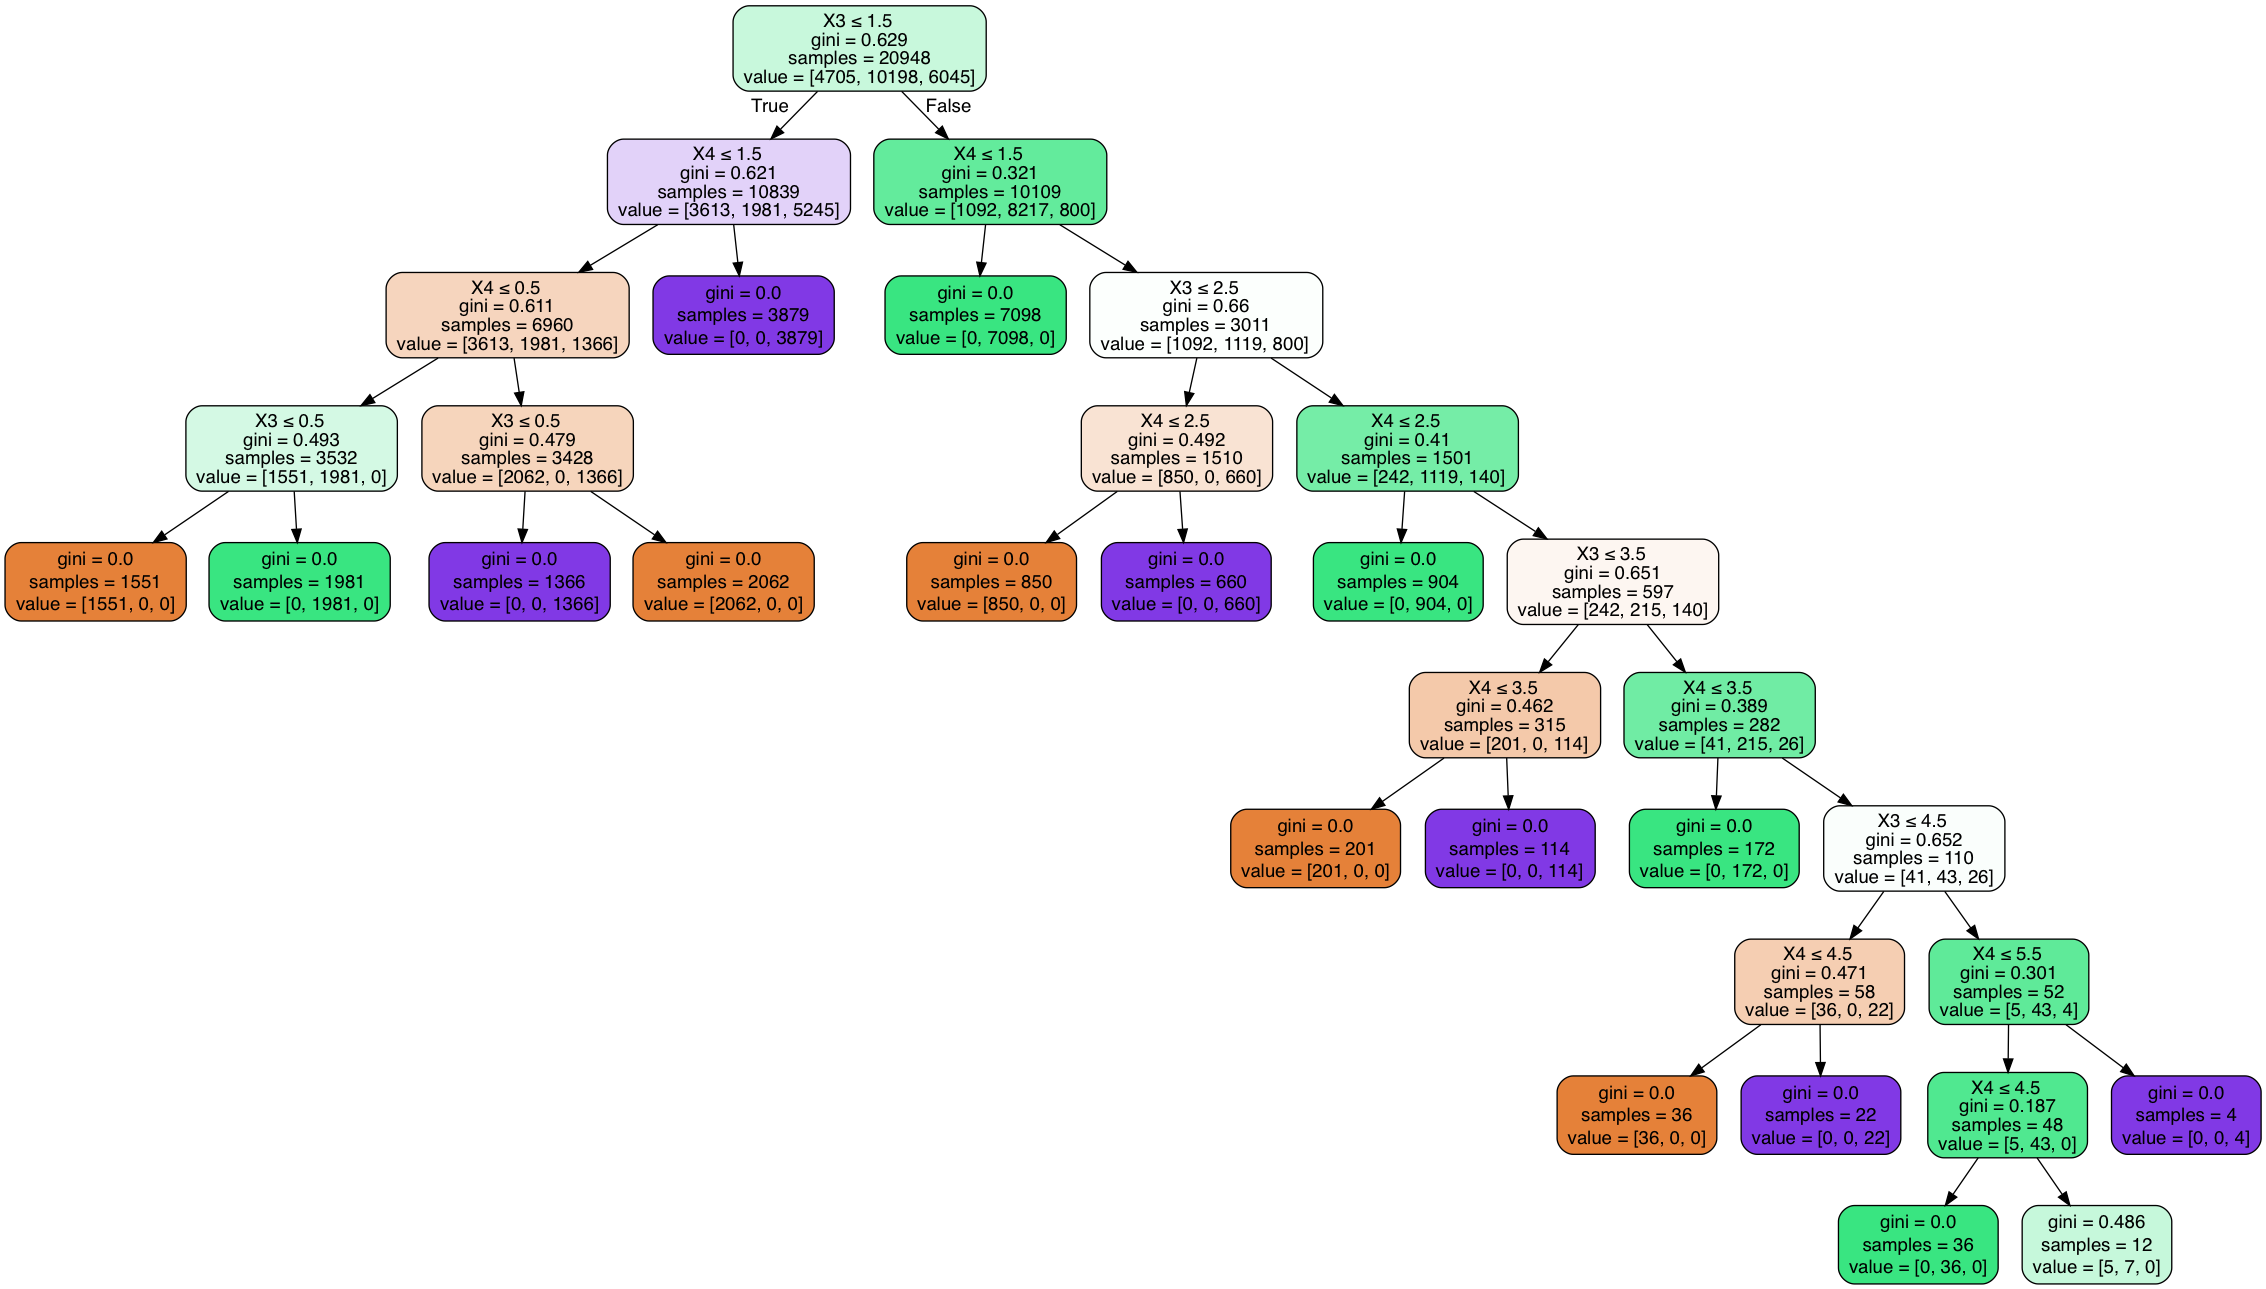

In [304]:
#Data visualization

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#Visualization Data
def visualize_tree(model_dt):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    
    dot_data = StringIO()
    export_graphviz(model_dt, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Callin the function for render Decison tree
visualize_tree(model_dt)
Image(graph.create_png())
